In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import pybiomart
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import warnings

#also need: igraph, leidenalg, louvain

matplotlib.rcParams.update({'font.size': 12})
warnings.simplefilter(action='ignore', category=FutureWarning)

# [Load in Data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174574)
We are using single-cell RNA sequencing (scRNA-seq) data. scRNA-seq is a popular technique for measuring gene expression at the single-cell level.

**The Technique:**
- Individual cells are isolated and captured
- RNA is extracted from each cell, converted to complementary DNA (cDNA), and amplified
- the cDNA libraries are sequenced to generate the transcriptome of each cell - which genes are expressed at at which levels

**The Data:**
- Gene expression matrix: the expression levels of genes in individual cells. Each row is a gene and each column is a cell.
- Barcodes: each cell is associated with a unique barcode that allows researchers to track expression profiles back to specific cells
- Genes: Information about genes detected in the cells (names, identifiers, expression levels)

In [2]:
# Load in control data sample 1: sham1

# Load the matrix data into an AnnData object
adata_sham1 = anndata.read_mtx("stroke_data/GSM5319987_sham1_matrix.mtx.gz") # genes by cells matrix
# Read the barcode and gene files
barcodes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_barcodes.tsv.gz", header=None)
genes_sham1 = pd.read_csv("stroke_data/GSM5319987_sham1_genes.tsv.gz", header=None)

# Load in control data sample 2: sham2

# Load the matrix data into an AnnData object
adata_sham2 = anndata.read_mtx("stroke_data/GSM5319988_sham2_matrix.mtx.gz") # genes by cells matrix
# Read the barcode and gene files
barcodes_sham2 = pd.read_csv("stroke_data/GSM5319988_sham2_barcodes.tsv.gz", header=None)
genes_sham2 = pd.read_csv("stroke_data/GSM5319988_sham2_genes.tsv.gz", header=None)

# Load in control data sample 3: sham3

# Load the matrix data into an AnnData object
adata_sham3 = anndata.read_mtx("stroke_data/GSM5319989_sham3_matrix.mtx.gz") # genes by cells matrix
# Read the barcode and gene files
barcodes_sham3 = pd.read_csv("stroke_data/GSM5319989_sham3_barcodes.tsv.gz", header=None)
genes_sham3 = pd.read_csv("stroke_data/GSM5319989_sham3_genes.tsv.gz", header=None)

# Load in stroke data sample 1: MCA01

# Load the matrix data into an AnnData object
adata_stroke1 = anndata.read_mtx("stroke_data/GSM5319990_MCAO1_matrix.mtx.gz") # genes by cells matrix
# Read the barcode and gene files
barcodes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_barcodes.tsv.gz", header=None)
genes_stroke1 = pd.read_csv("stroke_data/GSM5319990_MCAO1_genes.tsv.gz", header=None)

# Load in stroke data sample 2: MCA02

# Load the matrix data into an AnnData object
adata_stroke2 = anndata.read_mtx("stroke_data/GSM5319991_MCAO2_matrix.mtx.gz") # genes by cells matrix
# Read the barcode and gene files
barcodes_stroke2 = pd.read_csv("stroke_data/GSM5319991_MCAO2_barcodes.tsv.gz", header=None)
genes_stroke2 = pd.read_csv("stroke_data/GSM5319991_MCAO2_genes.tsv.gz", header=None)

# Load in stroke data sample 3: MCA03

# Load the matrix data into an AnnData object
adata_stroke3 = anndata.read_mtx("stroke_data/GSM5319992_MCAO3_matrix.mtx.gz") # genes by cells matrix
# Read the barcode and gene files
barcodes_stroke3 = pd.read_csv("stroke_data/GSM5319992_MCAO3_barcodes.tsv.gz", header=None)
genes_stroke3 = pd.read_csv("stroke_data/GSM5319992_MCAO3_genes.tsv.gz", header=None)

In [3]:
# Set the barcodes and genes as row and column names for each of the adata objects
adata_sham1.obs_names = genes_sham1[0]
adata_sham1.var_names = barcodes_sham1[0]

adata_sham2.obs_names = genes_sham2[0]
adata_sham2.var_names = barcodes_sham2[0]

adata_sham3.obs_names = genes_sham3[0]
adata_sham3.var_names = barcodes_sham3[0]

adata_stroke1.obs_names = genes_stroke1[0]
adata_stroke1.var_names = barcodes_stroke1[0]

adata_stroke2.obs_names = genes_stroke2[0]
adata_stroke2.var_names = barcodes_stroke2[0]

adata_stroke3.obs_names = genes_stroke3[0]
adata_stroke3.var_names = barcodes_stroke3[0]

In [4]:
data_mtx = {
    'sham1': adata_sham1,
    'sham2': adata_sham2,
    'sham3': adata_sham3,
    'stroke1': adata_stroke1,
    'stroke2': adata_stroke2,
    'stroke3': adata_stroke3,
}

In [5]:
# Transpose the adata matrices so that they are cells by genes, which our packages expect
for key, value in data_mtx.items():
    data_mtx[key] = value.transpose()
    print(f'{key} before QC: {value.n_obs} cells x {value.n_vars} genes')

sham1 before QC: 27998 cells x 8771 genes
sham2 before QC: 27998 cells x 8540 genes
sham3 before QC: 27998 cells x 9980 genes
stroke1 before QC: 27998 cells x 11772 genes
stroke2 before QC: 27998 cells x 11361 genes
stroke3 before QC: 27998 cells x 8104 genes


# Quality Control / Pre-Processing

## Test for Library Saturation
Library saturation is the point at which the sequencing depth is sufficient to capture the majority of expressed genes in each cell. It's the point at which increasing the number of transcripts detected in each cell (the unique molecular identifier/UMI counts) does not result in a proportional increase in the number of genes detected. If we have not "saturated" our sequencing library, then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

This is important for quality control because it will help us identify cells with low RNA content or other technical issues, which we should filter out.

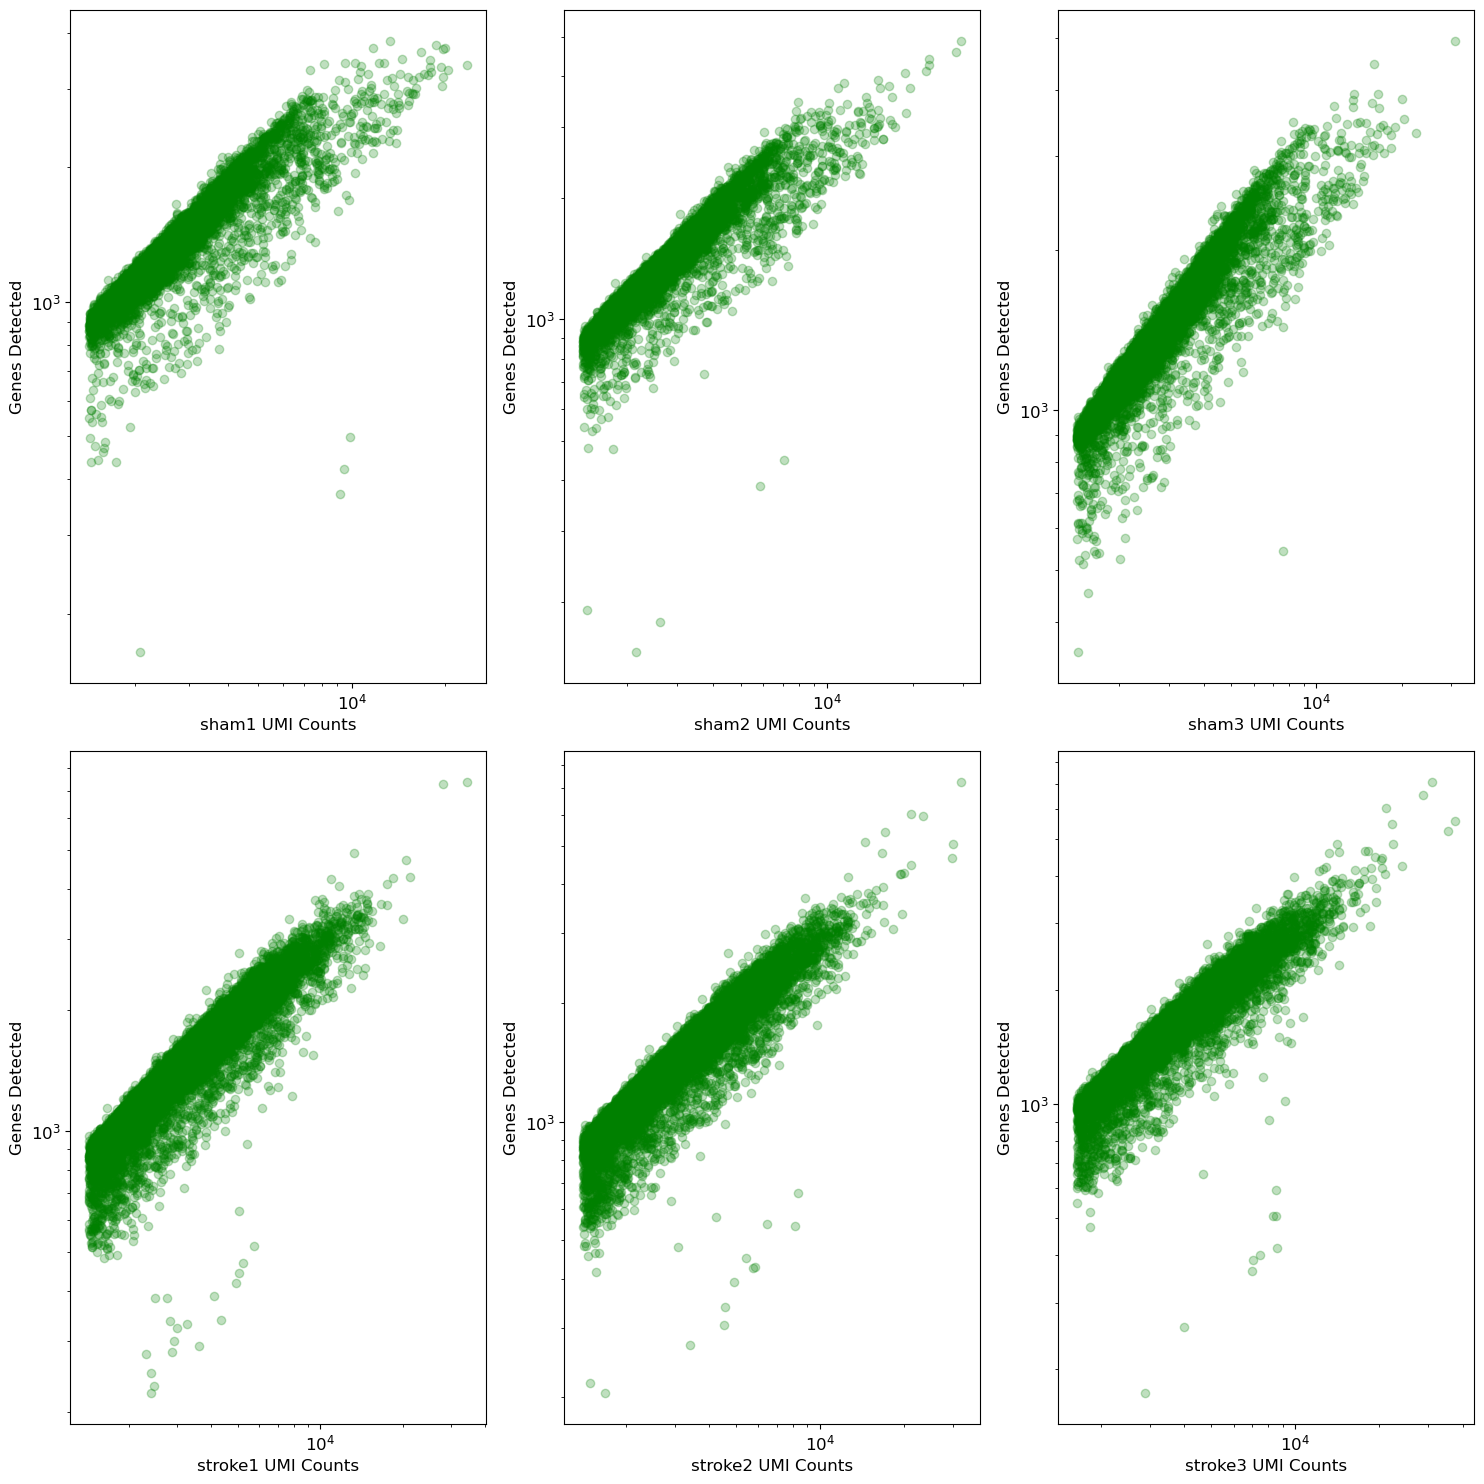

In [6]:
# Create plots of the 6 conditions showing genes detected vs UMI counts
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for idx, (key, value) in enumerate(data_mtx.items()):
    row = idx // 3
    col = idx % 3
    
    x = np.asarray(value.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(value.X > 0, axis=1))[:,0]
    
    axs[row, col].scatter(x, y, color="green", alpha=0.25)
    axs[row, col].set_xlabel(f"{key} UMI Counts")
    axs[row, col].set_ylabel("Genes Detected")
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')

plt.tight_layout()
plt.show()

## Examine the knee plot
"In this plot, cells are ordered by the number of UMI counts associated to them (shown on the x-axis), and the fraction of droplets with at least that number of cells is shown on the y-axis. The idea is that "real" cells have a certain number of UMI counts and that a threshold on the UMI counts filters those cells."

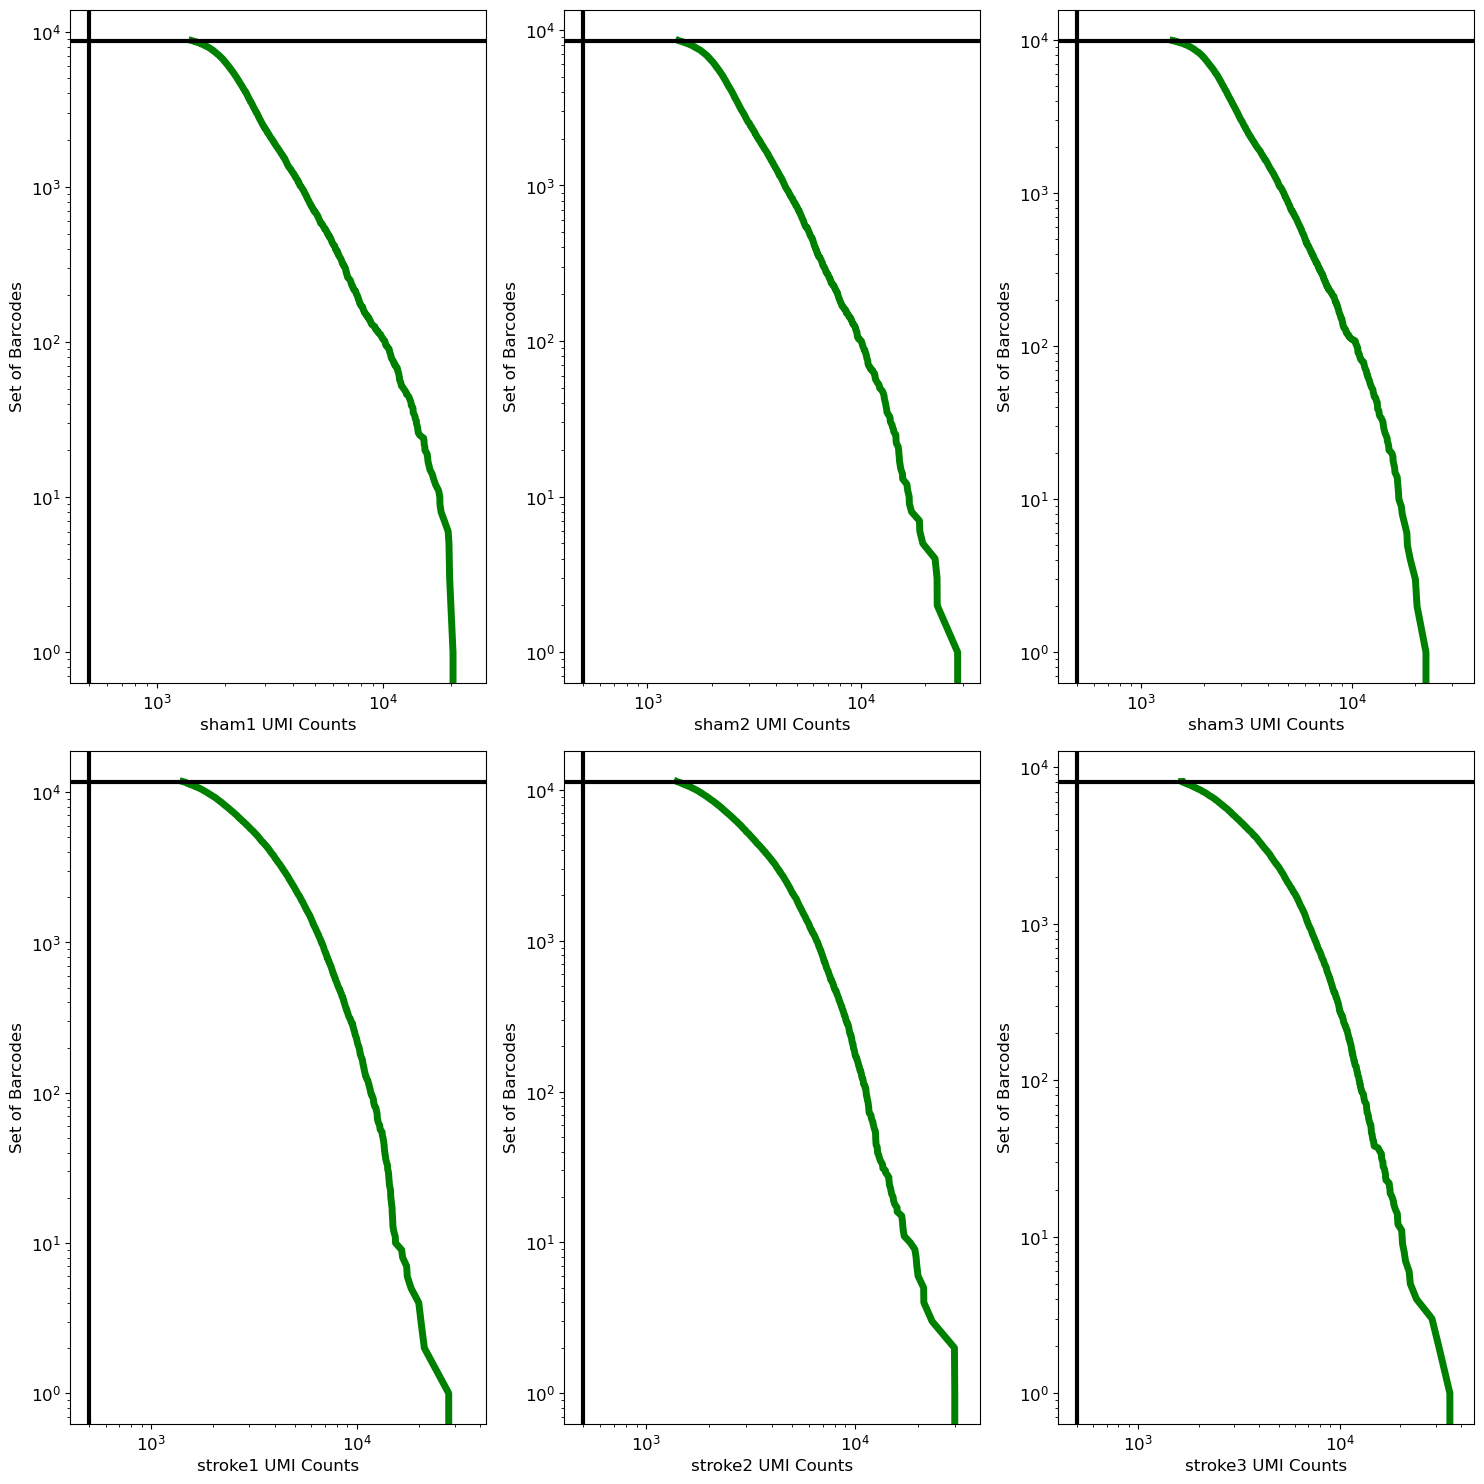

In [7]:
# Create knee plots of the 6 conditions 
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
cutoff = 500
umi_passes = {}

for idx, (key, value) in enumerate(data_mtx.items()):
    row = idx // 3
    col = idx % 3

    knee = np.sort((np.array(value.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]
    
    axs[row, col].loglog(knee, cell_set, linewidth=5, color="g")
    axs[row, col].axvline(x=cutoff, linewidth=3, color="k")
    axs[row, col].axhline(y=num_cells, linewidth=3, color="k")
    axs[row, col].set_xlabel(f"{key} UMI Counts")
    axs[row, col].set_ylabel("Set of Barcodes")

    cells_passed = value[:, value.X.sum(axis=0) > cutoff]
    umi_passes[key] = {
        'cells': cells_passed,
        'num_cells': len(cells_passed),
    }

plt.tight_layout()
plt.show()

In [8]:
for key, value in umi_passes.items():
    print(f"{value['num_cells']:,.0f} cells passed the {cutoff} UMI threshold in {key}")

8,771 cells passed the 500 UMI threshold in sham1
8,540 cells passed the 500 UMI threshold in sham2
9,980 cells passed the 500 UMI threshold in sham3
11,772 cells passed the 500 UMI threshold in stroke1
11,361 cells passed the 500 UMI threshold in stroke2
8,104 cells passed the 500 UMI threshold in stroke3


## Filter empty droplets
For each of the conditions, filter the cells according to the threshold determined from the knee plot

In [9]:
for key, value in data_mtx.items():
    data_mtx[key] = umi_passes[key]['cells']

## Filter by Mitochondrial Content
Filter out cells with high mitochondrial content, as this signals apoptotic processes and cellular stress; we also care more about nuclear genome than mitochondrial genome

In [10]:
# Get the ids for mitochondrial genes
mito_ensembl_ids = sc.queries.mitochondrial_genes("mmusculus", attrname="ensembl_gene_id")

In [11]:
# Separate the gene id from the symbol so we can search by gene id
# This will be used later to find cells in our dataset with mitochondrial genes and label our UMAP plots
for key, value in data_mtx.items():
    gene_ids = []
    gene_symbols = []
    for gene_name in value.var_names:
        gene_id, gene_symbol = gene_name.split('\t')
        gene_ids.append(gene_id)
        gene_symbols.append(gene_symbol)
    
    # Add gene_id and gene_symbol columns to value.var
    value.var['gene_id'] = gene_ids
    value.var['gene_symbol'] = gene_symbols

/var/folders/rx/fgz1787n08s_xkvzdrlrj4sm0000gn/T/ipykernel_87027/1555895938.py:28: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  value.var['gene_id'] = gene_ids
/var/folders/rx/fgz1787n08s_xkvzdrlrj4sm0000gn/T/ipykernel_87027/1555895938.py:28: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  value.var['gene_id'] = gene_ids
/var/folders/rx/fgz1787n08s_xkvzdrlrj4sm0000gn/T/ipykernel_87027/1555895938.py:28: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  value.var['gene_id'] = gene_ids
/var/folders/rx/fgz1787n08s_xkvzdrlrj4sm0000gn/T/ipykernel_87027/1555895938.py:28: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  value.var['gene_id'] = gene_ids
/var/folders/rx/fgz1787n08s_xkvzdrlrj4sm0000gn/T/ipykernel_87027/1555895938.py:28: ImplicitModificationWarning: Trying to modify

In [12]:
mito_genes = mito_ensembl_ids["ensembl_gene_id"].values

for key, value in data_mtx.items():
    # Compute the indices of mitochondrial genes in the 6 conditions
    mito_gene_indices = []
    for gene_id in mito_genes:
        # Extract gene ID without additional information
        gene_id_without_info = gene_id.split('\t')[0]
        # Find indices where the gene ID matches
        indices = np.where(value.var['gene_id'].str.split('\t').str[0] == gene_id_without_info)[0]
        if len(indices) > 0:
            # mito_gene_indices.append(indices[0])
            mito_gene_indices.extend(indices)

    # Compute the fraction of counts in mitochondrial genes vs. all genes for each cell
    value.obs['percent_mito'] = np.sum(value[:, mito_gene_indices].X, axis=1).A1 / np.sum(value.X, axis=1).A1
    
    # Add the total counts per cell as observations-annotation to adata
    value.obs['n_counts'] = value.X.sum(axis=1).A1

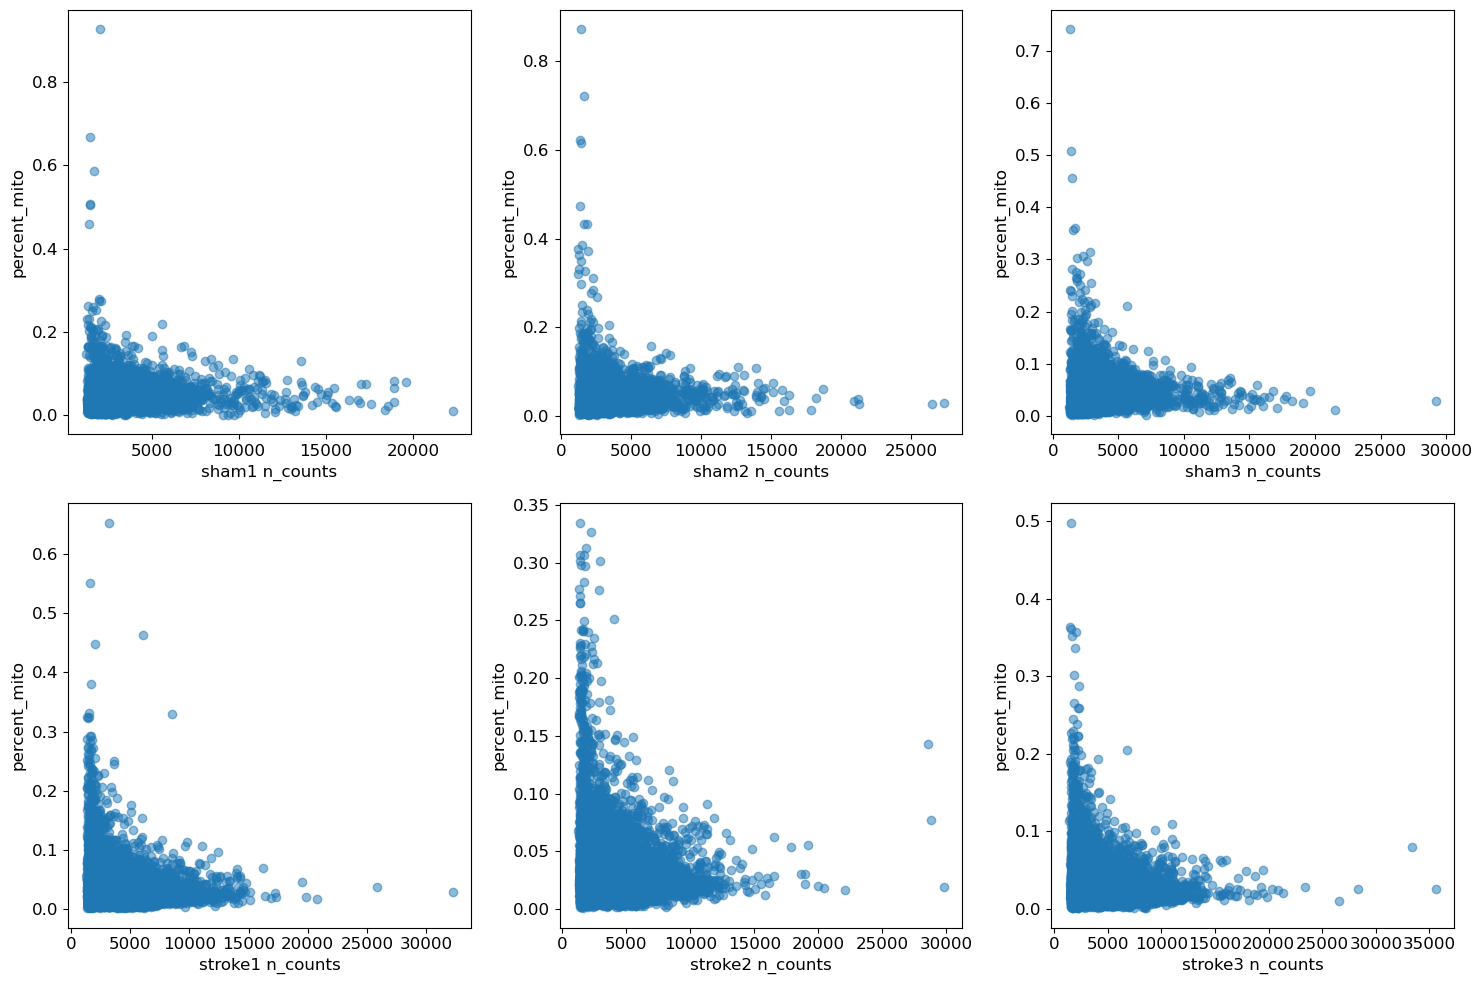

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create plots of the 6 conditions showing counts vs percent mitochondrial content
for idx, (key, value) in enumerate(data_mtx.items()):
    ax = axs[idx // 3, idx % 3]
    ax.scatter(value.obs['n_counts'], value.obs['percent_mito'], alpha=0.5)
    ax.set_xlabel(f'{key} n_counts')
    ax.set_ylabel('percent_mito')

plt.tight_layout()
plt.show()

## Filter Out Genes Not in Any Cell
Remove genes that have negligible expression across cells to eliminate noise

In [14]:
# For each of the 6 conditions, filter out genes with negligible expression across cells (less than 3)
for key, value in data_mtx.items():
    val_copy = value.copy()
    sc.pp.filter_genes(val_copy, min_cells=3)
    data_mtx[key] = val_copy

## Visualize Count Distributions
Evaluate violin plots for n_genes, n_counts, and percent_mito

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


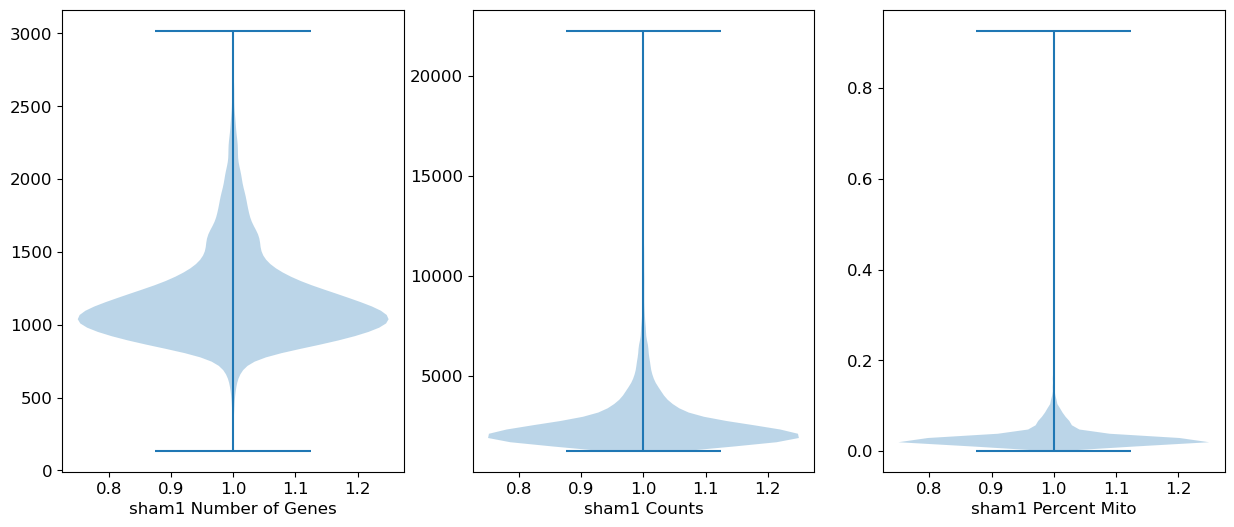

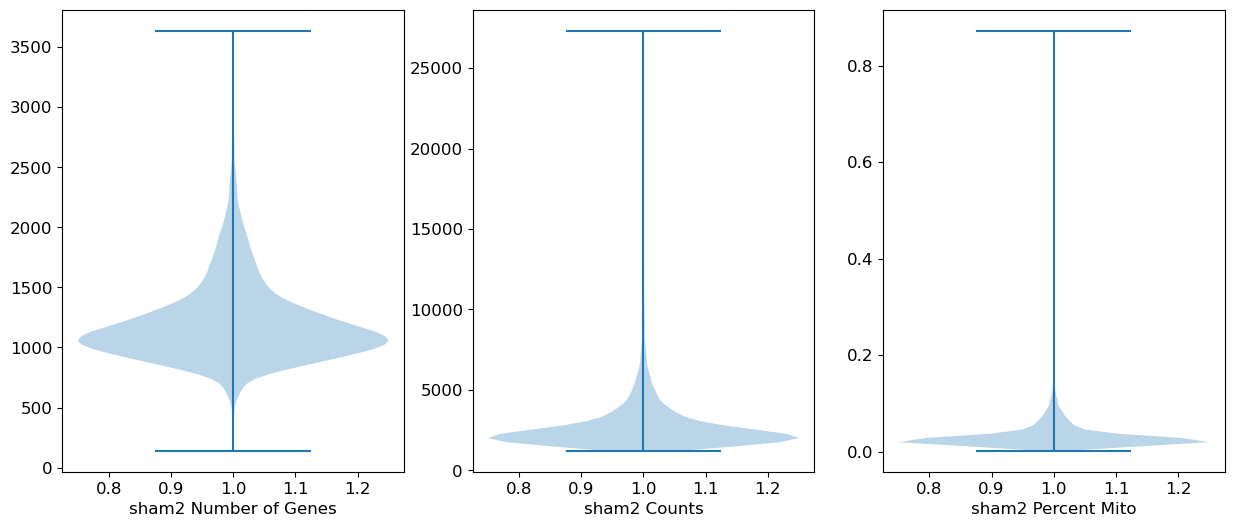

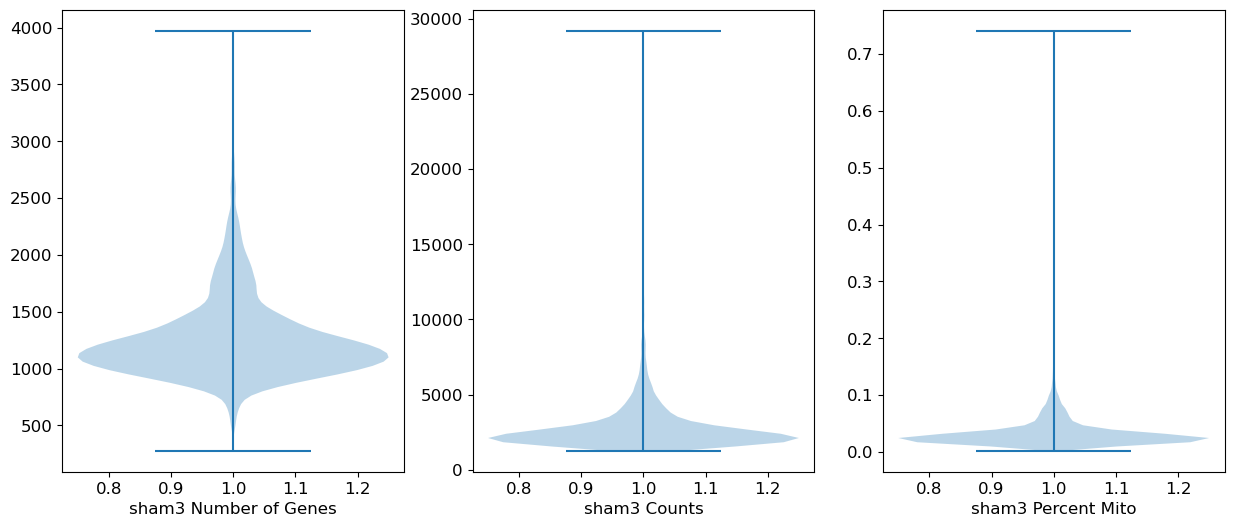

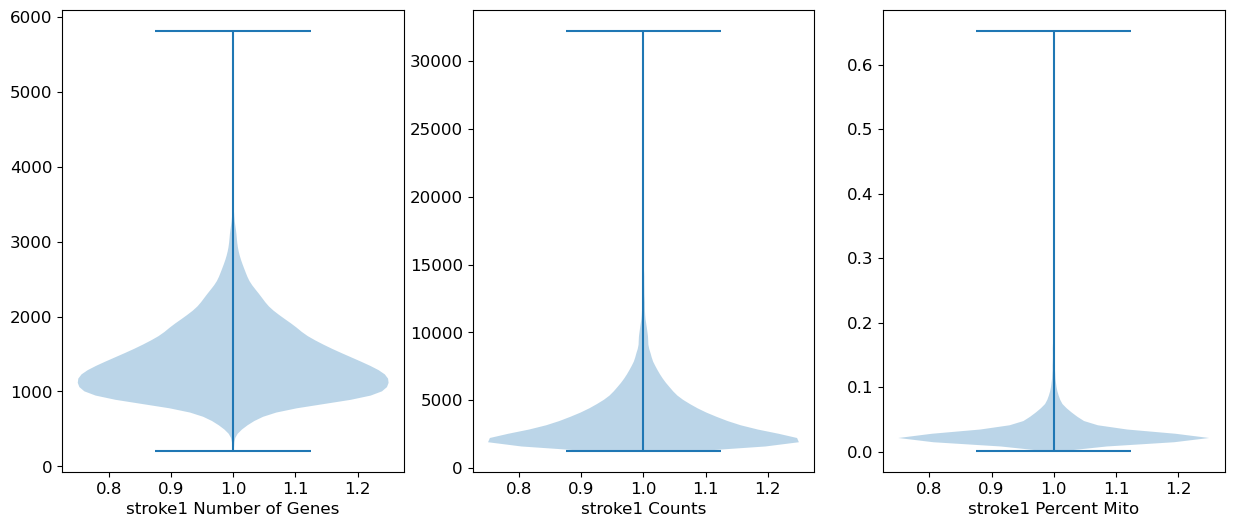

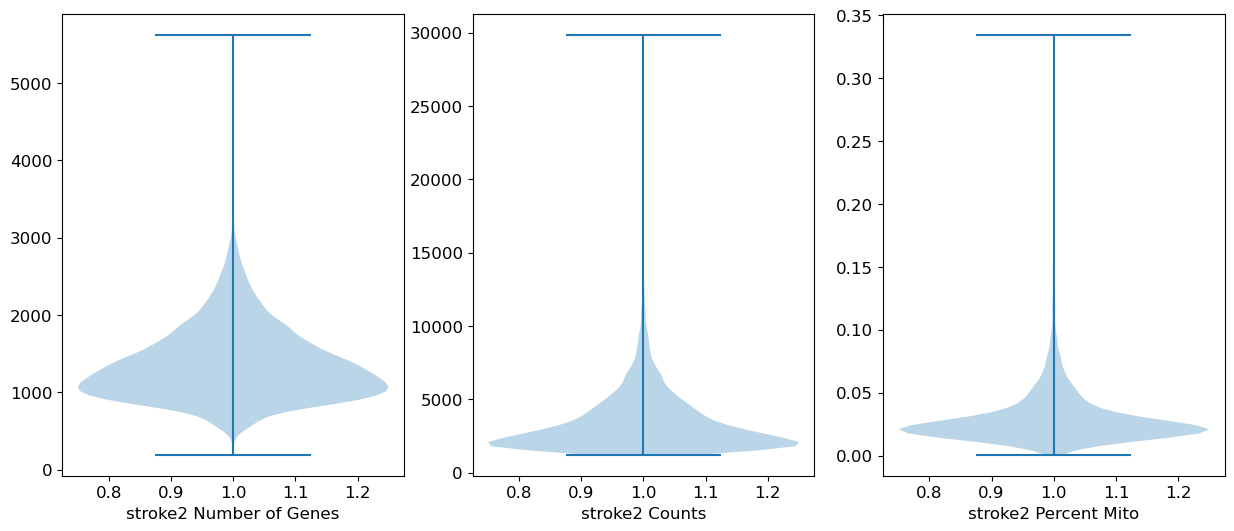

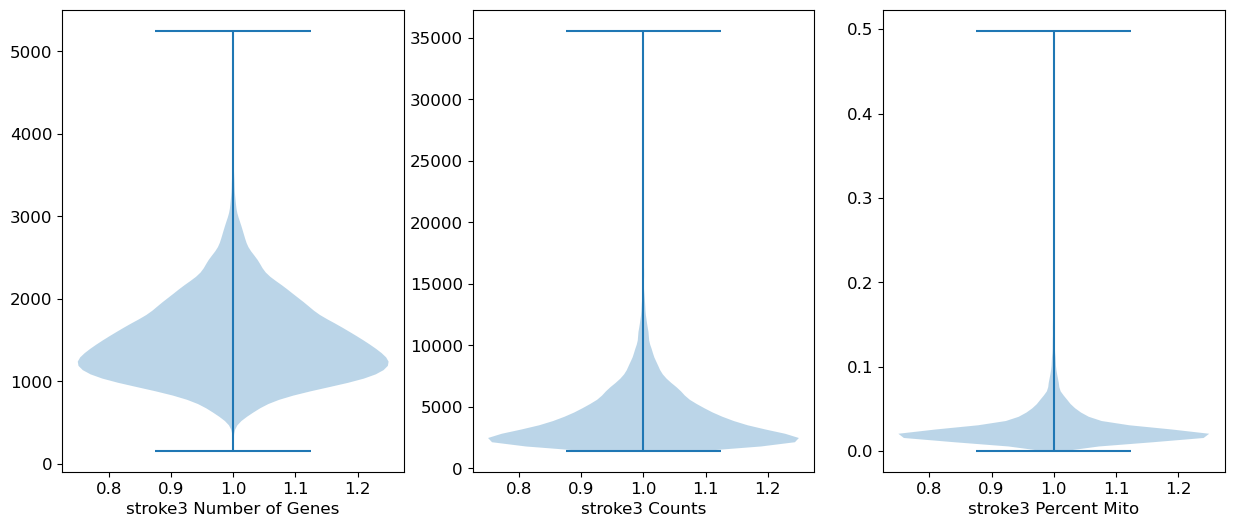

In [15]:
for idx, (key, value) in enumerate(data_mtx.items()):
    sc.pp.calculate_qc_metrics(data_mtx[key], inplace=True)
    value.obs['n_genes'] = (value.X > 0).sum(axis=1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    
    axs[0].violinplot(dataset=value.obs['n_genes'])
    axs[0].set_xlabel(f'{key} Number of Genes')
    axs[1].violinplot(dataset=value.obs['n_counts'])
    axs[1].set_xlabel(f'{key} Counts')
    axs[2].violinplot(dataset=value.obs['percent_mito'])
    axs[2].set_xlabel(f'{key} Percent Mito')

In [16]:
# For each of the 6 conditions, filter out cells with less than 3% mitochondrial content
for key, value in data_mtx.items():
   data_mtx[key] = value[value.obs.percent_mito < 0.03]

In [17]:
# Filter cells with low gene count
for key, value in data_mtx.items():
    sc.pp.filter_cells(value, min_genes=500)

/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


# Analysis
Inspired by https://www.kallistobus.tools/tutorials/kb_getting_started/python/kb_intro_2_python/#examine-the-knee-plot

## Normalize the Counts

In [18]:
for key, value in data_mtx.items():
    sc.pp.normalize_per_cell(data_mtx[key], counts_per_cell_after=1e4)
    sc.pp.log1p(data_mtx[key])

## Identify Highly Variable Genes

sham1:


/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


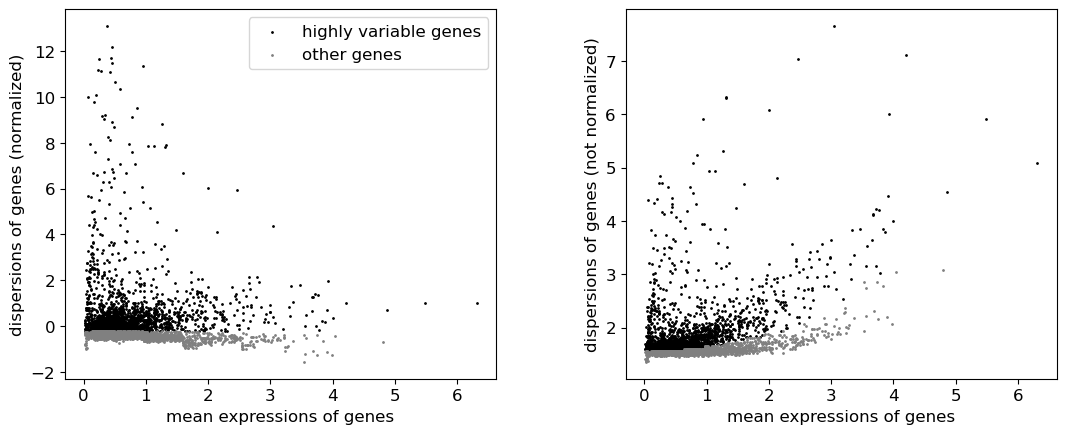

sham2:


/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


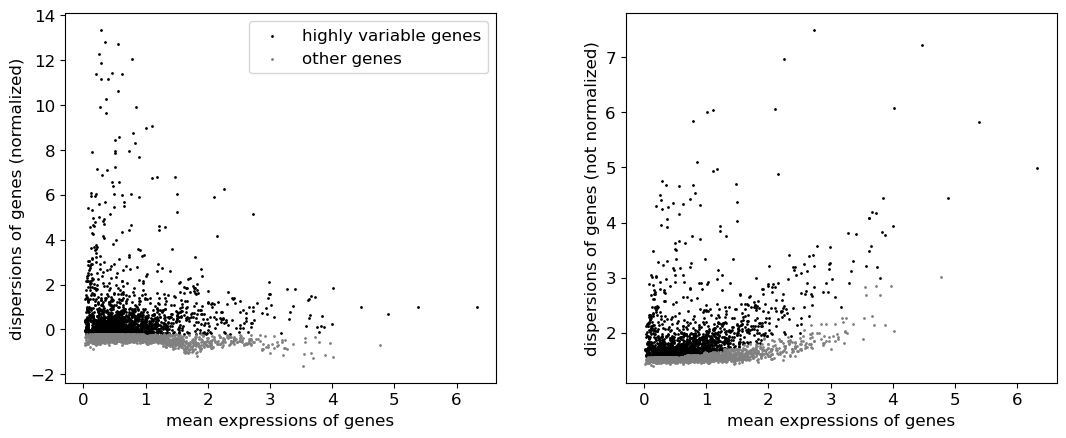

sham3:


/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


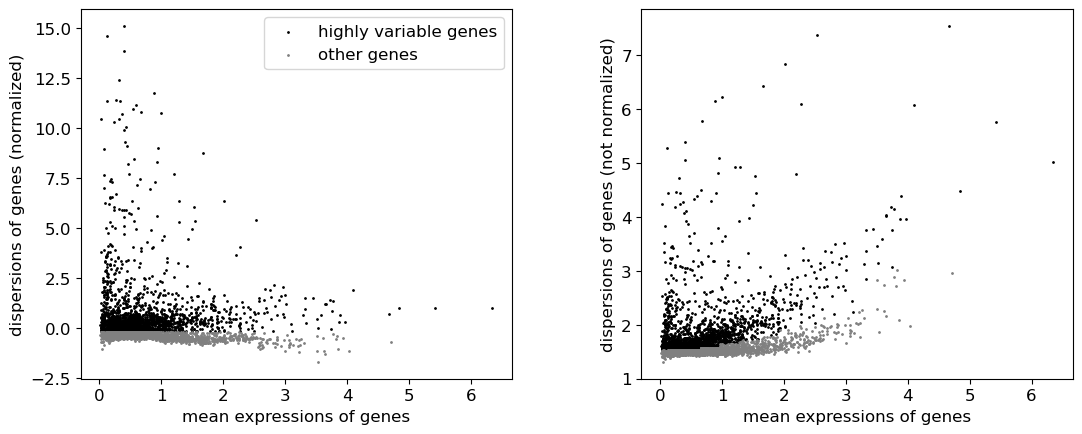

stroke1:


/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


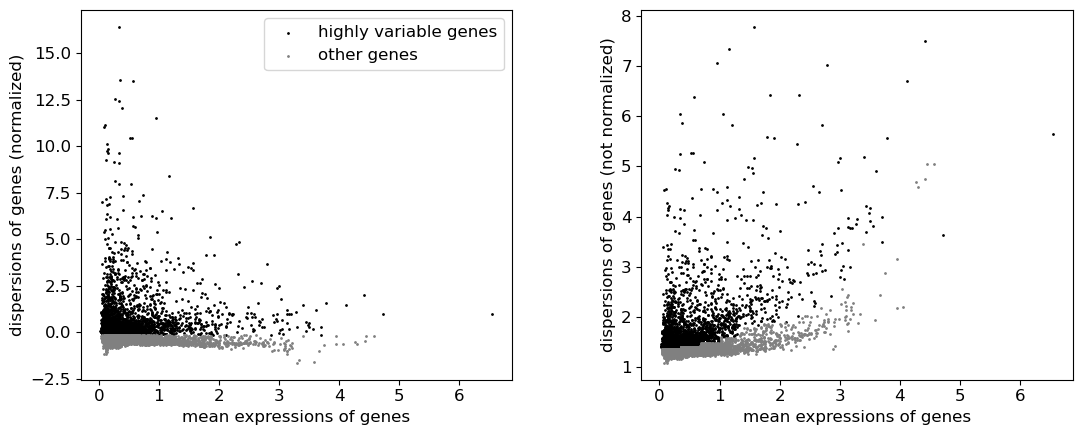

stroke2:


/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


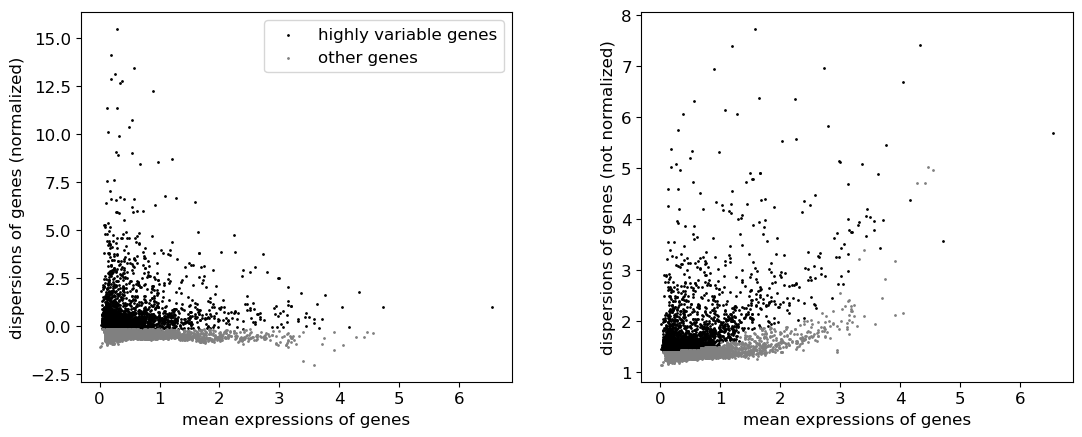

stroke3:


/Users/owenzel/micromamba/envs/cs109a/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


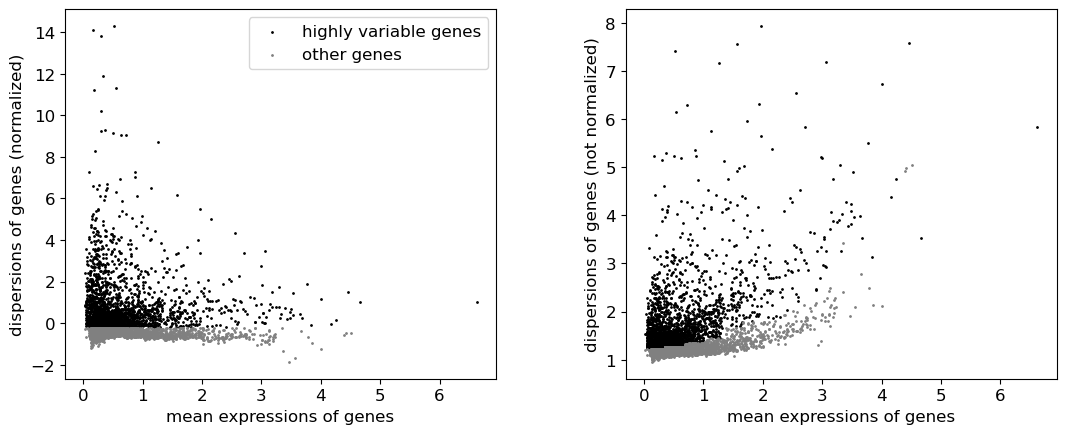

In [21]:
for (key, value) in data_mtx.items():
    print(f"{key}:")
    sc.pp.highly_variable_genes(value, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
    sc.pl.highly_variable_genes(value)

In [22]:
for key, value in data_mtx.items():
    sc.pp.scale(value, max_value=10)

## Clustering & visualization
"Louvain clustering is a popular method for clustering single-cell RNA-seq data. The method was published in

Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008."

In [23]:
for key, value in data_mtx.items():
    sc.tl.pca(value, svd_solver='arpack', use_highly_variable=True, n_comps=10)
    sc.pp.neighbors(value, n_neighbors=30, n_pcs=10, knn=True)
    sc.tl.louvain(value)

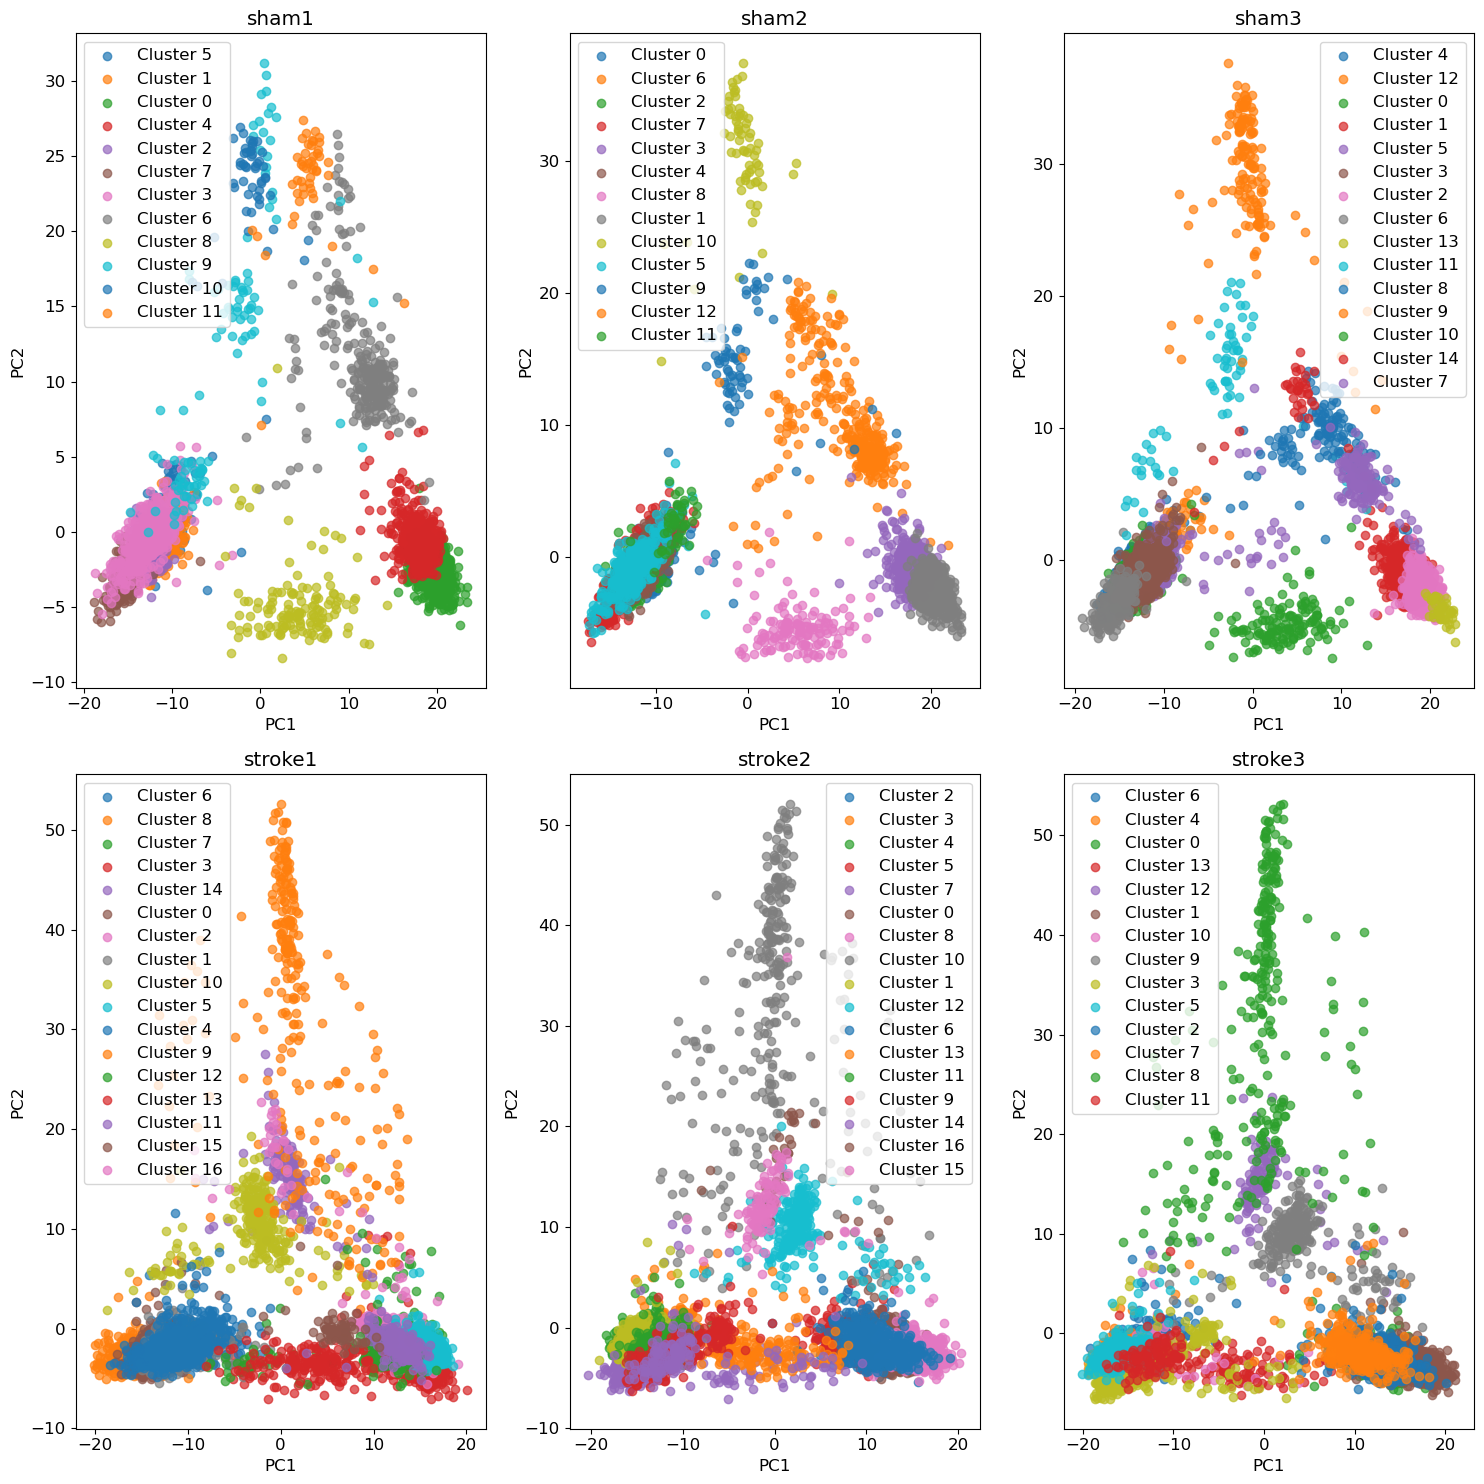

In [26]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, axs = plt.subplots(2, 3, figsize=(15, 15))

for idx, (key, value) in enumerate(data_mtx.items()):
    row = idx // 3
    col = idx % 3

    # Get the first 2 principal components & Louvain clusters
    pcs = value.obsm['X_pca'][:, :2]
    clusters = value.obs['louvain']
    
    for cluster in clusters.unique():
        cluster_indices = (clusters == cluster)
        axs[row, col].scatter(pcs[cluster_indices, 0], pcs[cluster_indices, 1], label=f'Cluster {cluster}', alpha=0.7)

    axs[row, col].set_xlabel('PC1')
    axs[row, col].set_ylabel('PC2')
    axs[row, col].set_title(key)
    axs[row, col].legend()

plt.tight_layout()
plt.show()

## Principal Component Analysis Variance Ratio
Determine the extent to which PC1 and PC2 explain the majority of the variance we see in the data

sham1:


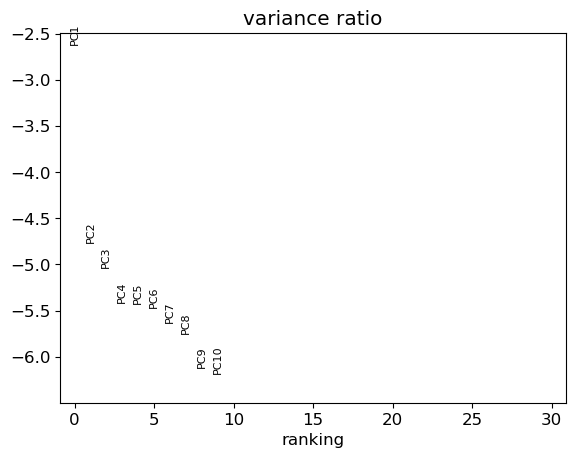

sham2:


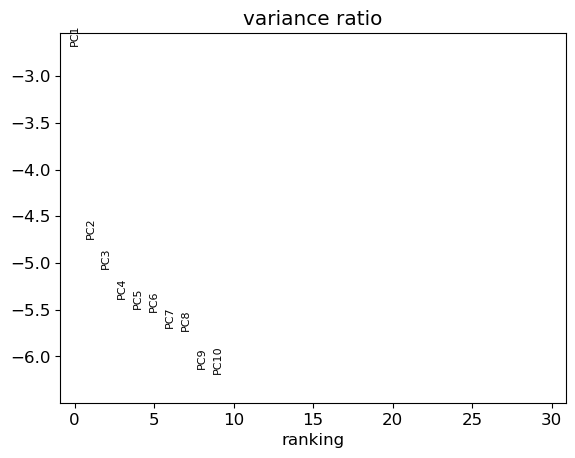

sham3:


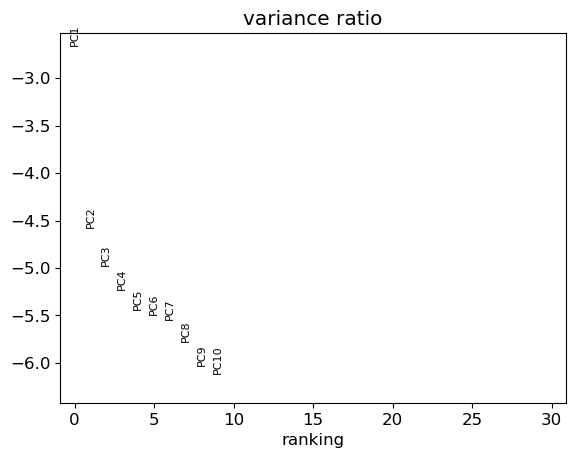

stroke1:


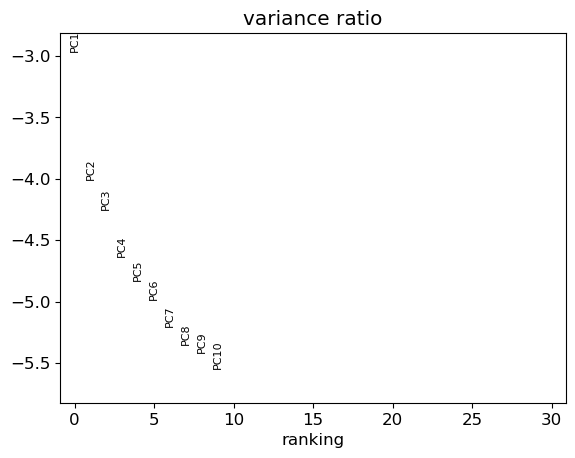

stroke2:


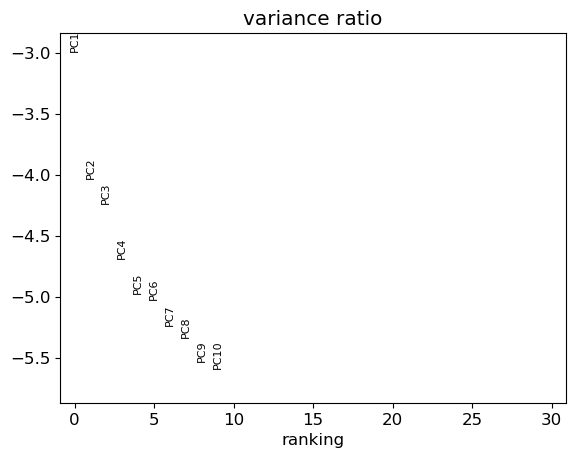

stroke3:


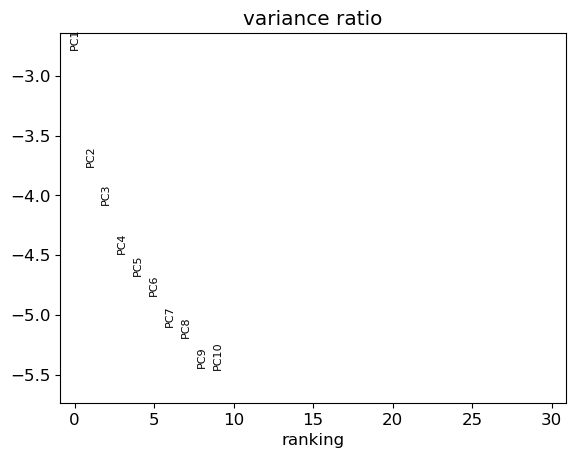

In [27]:
for (key, value) in data_mtx.items():
    print(f"{key}:")
    sc.pl.pca_variance_ratio(value, log=True)

## UMAP
"UMAP stands for Uniform Manifold Approximation and Projection is a non-linear dimensionality reduction techinque described in

Leland McInnes and John Healy and James Melville, "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction" 2018 1802.03426 arXiv stat.ML"

In [ ]:
sc.tl.umap(adata_stroke1)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata_stroke1, color='louvain', ax=ax)

## Annotation Strategy
Here we will identify genes with differential expression among each cluster, looking to identify
cellular gene markers that may define the cluster as a whole through downstream feature plots.

In [ ]:
sc.tl.rank_genes_groups(adata_stroke1, 'louvain', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(adata_stroke1, n_genes=25, sharey=False)